# MODEL 5_LSS_split10
### Contains all fixed-before-conditional trials, regardless of interfering BL
### Combines A & C trials into single regressor
### Analysis isolated to 10 before and 10 after trials surrounding largest deviation (point of greatest learning)

#  WMAZE Beta Series Correlation Analysis

## Obtains correlation values for the regions of interest:
### Hippocampus (FS labels: hippocampus [17, 53])
### Dorsal caudate (hand-drawn by Mandy)
### Medial PFC (FS labels: rostral anterior cingulate [1026, 2026] & caudal anterior cingulate [1002, 2002])
### Dorsolateral PFC (Lausanne atlas: dlPFC)

### Use Glob to grab all previously created anatomy masks and beta series cope files

In [4]:
from glob import glob
sids = ['WMAZE_001']

#sids = ['WMAZE_001', 'WMAZE_004', 'WMAZE_005', 'WMAZE_006', 
#        'WMAZE_007', 'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012',
#        'WMAZE_017', 'WMAZE_019', 'WMAZE_021',  
#        'WMAZE_022', 'WMAZE_023', 'WMAZE_024', 'WMAZE_026', 'WMAZE_027']

proj_dir = '/home/data/madlab/data/mri/wmaze'
 
mask_filenames = []
cope_files = []

for SID in sids:
    # Grab the mask files for each subject
    mask_filenames_glob = glob(proj_dir + '/roi_analysis/mask/anat_masks/_subject_id_' + SID + '/_anatmask_xfm*/*')
    mask_filenames.append(sorted(mask_filenames_glob))
    # Grab the cope files for each subject
    subjcopes_glob = glob(proj_dir + '/frstlvl/wmaze_MRthesis/fixed_before_conditional/model5_LSS_split10/merge_copes/'
                          + SID + '/merged/*')
    cope_files.append(sorted(subjcopes_glob))
    # If there are no cope files, print subject id
    if len(cope_files[-1]) == 0:
        print(SID)

### Cell to double-check the array indexing for both the masks and the copes

In [3]:
print '0. left dlPFC'
print(mask_filenames[0][0]) #lh-dlPFC Lausanne
print""
print '1. left hippocampus'
print(mask_filenames[0][1]) #lh-hippocampus
print""
print '2. left mPFC (rac-only)'
print(mask_filenames[0][2]) #lh-mPFC_rac-only
print""
print '3. left mPFC (orig)'
print(mask_filenames[0][3]) #lh-mPFC (orig)
print""
print '4. left putamen'
print(mask_filenames[0][4]) #lh-putamen
print""
print '5. left caudate'
print(mask_filenames[0][5]) #lh-caudate
print""
print '6. right dlPFC'
print(mask_filenames[0][6]) #rh-dlPFC Lausanne
print""
print '7. right hippocampus'
print(mask_filenames[0][7]) #rh-hippocampus
print""
print '8. right mPFC (orig)'
print(mask_filenames[0][8]) #rh-mPFC (orig)
print""
print '9. right putamen'
print(mask_filenames[0][9]) #rh-putamen
print""
print '10. right caudate'
print(mask_filenames[0][10]) #rh-caudate
print""
print '11. right mPFC (rac-only)'
print(mask_filenames[0][11]) #rh-mPFC_rac_only
print""
print '12. left mPFC (rac-cac)'
print(mask_filenames[0][12]) #lh-mPFC_rac-cac
print""
print '13. right mPFC (rac-cac)'
print(mask_filenames[0][13]) #rh-mPFC_rac-cac
print""

print '-----'

print 'frst10_cope_corr'
print(cope_files[0][0]) 
print ""
print 'frst10_cope_incorr'
print(cope_files[0][1])
print ""
print 'last10_cope_corr'
print(cope_files[0][2]) 
print ""
print 'last10_cope_incorr'
print(cope_files[0][3]) 

#for i in cope_files:
#    print(len(i))


0. left dlPFC
/home/data/madlab/data/mri/wmaze/roi_analysis/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm0/lh-dlPFC_lausanne_warped.nii.gz

1. left hippocampus
/home/data/madlab/data/mri/wmaze/roi_analysis/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm0/lh-hippocampus_warped.nii.gz

2. left mPFC (rac-only)
/home/data/madlab/data/mri/wmaze/roi_analysis/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm0/lh-mPFC_rac-only_warped.nii.gz

3. left mPFC (orig)
/home/data/madlab/data/mri/wmaze/roi_analysis/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm0/lh-mPFC_warped.nii.gz

4. left putamen
/home/data/madlab/data/mri/wmaze/roi_analysis/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm0/lh-putamen_warped.nii.gz

5. left caudate
/home/data/madlab/data/mri/wmaze/roi_analysis/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm0/lh_caudate_anat_mask_warped.nii.gz

6. right dlPFC
/home/data/madlab/data/mri/wmaze/roi_analysis/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm0/rh

### Use binarized mask to obtain activation in left & right hemisphere for each ROI

In [9]:
import nibabel as nb
import pandas as pd
import numpy as np
from scipy import stats


#Dictionary containing multiple arrays referenced by keywords
all_data = {'subjid':[],
            #first10
            'lh_hp_corr_F10':[], 'rh_hp_corr_F10':[], 
            'lh_hp_incorr_F10':[], 'rh_hp_incorr_F10':[],                 
            'lh_caudate_corr_F10':[], 'rh_caudate_corr_F10':[], 
            'lh_caudate_incorr_F10':[], 'rh_caudate_incorr_F10':[],  
            'lh_dlPFC_corr_F10':[], 'rh_dlPFC_corr_F10':[], 
            'lh_dlPFC_incorr_F10':[], 'rh_dlPFC_incorr_F10':[],            
            'lh_mPFC_corr_F10':[], 'rh_mPFC_corr_F10':[], 
            'lh_mPFC_incorr_F10':[], 'rh_mPFC_incorr_F10':[],
            #last10
            'lh_hp_corr_L10':[], 'rh_hp_corr_L10':[], 
            'lh_hp_incorr_L10':[], 'rh_hp_incorr_L10':[],                 
            'lh_caudate_corr_L10':[], 'rh_caudate_corr_L10':[], 
            'lh_caudate_incorr_L10':[], 'rh_caudate_incorr_L10':[],  
            'lh_dlPFC_corr_L10':[], 'rh_dlPFC_corr_L10':[], 
            'lh_dlPFC_incorr_L10':[], 'rh_dlPFC_incorr_L10':[],            
            'lh_mPFC_corr_L10':[], 'rh_mPFC_corr_L10':[], 
            'lh_mPFC_incorr_L10':[], 'rh_mPFC_incorr_L10':[]}

corr_matrix = np.zeros((len(sids), 9))

# For each interation in the length of subject ids
for i in range(len(sids)):
    #Append the subject id
    all_data['subjid'].append(sids[i])
    #Load the left and right hippocampus mask files using Nibabel 
    lh_hp_img = nb.load(mask_filenames[i][1])
    rh_hp_img = nb.load(mask_filenames[i][7])
    
    lh_caudate_img = nb.load(mask_filenames[i][5])
    rh_caudate_img = nb.load(mask_filenames[i][10])
    
    lh_dlPFC_img = nb.load(mask_filenames[i][0])
    rh_dlPFC_img = nb.load(mask_filenames[i][6])
    
    lh_mPFC_img = nb.load(mask_filenames[i][12]) #raccac
    rh_mPFC_img = nb.load(mask_filenames[i][13]) #raccac
    
    #Load copes for corr vs incorr betas
    F10_cope_corr_img = nb.load(cope_files[i][0])
    print F10_cope_corr_img.shape
    F10_cope_incorr_img = nb.load(cope_files[i][1])
    print F10_cope_incorr_img.shape
    L10_cope_corr_img = nb.load(cope_files[i][2])
    print L10_cope_corr_img.shape
    L10_cope_incorr_img = nb.load(cope_files[i][3])
    print L10_cope_incorr_img.shape
     
  
    ########################
    ### Left Hippocampus ###
    ########################
    
    # F10 cope_corr
    lh_hp_corr_F10_data = F10_cope_corr_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lh_hp_corr_F10'].append(lh_hp_corr_F10_data[0:-1])
    #print lh_hp_corr_F10_data
    
    # F10 cope_incorr
    lh_hp_incorr_F10_data = F10_cope_incorr_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lh_hp_incorr_F10'].append(lh_hp_incorr_F10_data[0:-1])
    #print lh_hp_incorr_F10_data
    
    # L10 cope_corr
    lh_hp_corr_L10_data = L10_cope_corr_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lh_hp_corr_L10'].append(lh_hp_corr_L10_data[0:-1])
  
    # L10 cope_incorr
    lh_hp_incorr_L10_data = L10_cope_incorr_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lh_hp_incorr_L10'].append(lh_hp_incorr_L10_data[0:-1])
    
    #########################
    ### Right Hippocampus ###
    #########################
    
    # F10 cope_corr
    rh_hp_corr_F10_data = F10_cope_corr_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rh_hp_corr_F10'].append(rh_hp_corr_F10_data[0:-1])

    # F10 cope_incorr
    rh_hp_incorr_F10_data = F10_cope_incorr_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rh_hp_incorr_F10'].append(rh_hp_incorr_F10_data[0:-1])
    
    # L10 cope_corr
    rh_hp_corr_L10_data = L10_cope_corr_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rh_hp_corr_L10'].append(rh_hp_corr_L10_data[0:-1])

    # L10 cope_incorr
    rh_hp_incorr_L10_data = L10_cope_incorr_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rh_hp_incorr_L10'].append(rh_hp_incorr_L10_data[0:-1])
    
    #####################
    ### Left Caudate ###
    ##################### 
    
    # F10 cope_corr
    lh_caudate_corr_F10_data = F10_cope_corr_img.get_data()[lh_caudate_img.get_data() > 0.]
    all_data['lh_caudate_corr_F10'].append(lh_caudate_corr_F10_data[0:-1])

    # F10 cope_incorr
    lh_caudate_incorr_F10_data = F10_cope_incorr_img.get_data()[lh_caudate_img.get_data() > 0.]
    all_data['lh_caudate_incorr_F10'].append(lh_caudate_incorr_F10_data[0:-1])
    
    # L10 cope_corr
    lh_caudate_corr_L10_data = L10_cope_corr_img.get_data()[lh_caudate_img.get_data() > 0.]
    all_data['lh_caudate_corr_L10'].append(lh_caudate_corr_L10_data[0:-1])

    # L10 cope_incorr
    lh_caudate_incorr_L10_data = L10_cope_incorr_img.get_data()[lh_caudate_img.get_data() > 0.]
    all_data['lh_caudate_incorr_L10'].append(lh_caudate_incorr_L10_data[0:-1])
    
    #####################
    ### Right Caudate ###
    ##################### 
    
    # F10_cope_corr
    rh_caudate_corr_F10_data = F10_cope_corr_img.get_data()[rh_caudate_img.get_data() > 0.]
    all_data['rh_caudate_corr_F10'].append(rh_caudate_corr_F10_data[0:-1])

    # F10_cope_incorr
    rh_caudate_incorr_F10_data = F10_cope_incorr_img.get_data()[rh_caudate_img.get_data() > 0.]
    all_data['rh_caudate_incorr_F10'].append(rh_caudate_incorr_F10_data[0:-1])  
    
    # L10_cope_corr
    rh_caudate_corr_L10_data = L10_cope_corr_img.get_data()[rh_caudate_img.get_data() > 0.]
    all_data['rh_caudate_corr_L10'].append(rh_caudate_corr_L10_data[0:-1])

    # L10_cope_incorr
    rh_caudate_incorr_L10_data = L10_cope_incorr_img.get_data()[rh_caudate_img.get_data() > 0.]
    all_data['rh_caudate_incorr_L10'].append(rh_caudate_incorr_F10_data[0:-1])  
    
    ####################
    #### Left mPFC #####
    ####################
    
    # F10_cope_corr
    lh_mPFC_corr_F10_data = F10_cope_corr_img.get_data()[lh_mPFC_img.get_data() > 0.]
    all_data['lh_mPFC_corr_F10'].append(lh_mPFC_corr_F10_data[0:-1])
    
    # F10_cope_incorr
    lh_mPFC_incorr_F10_data = F10_cope_incorr_img.get_data()[lh_mPFC_img.get_data() > 0.]
    all_data['lh_mPFC_incorr_F10'].append(lh_mPFC_incorr_F10_data[0:-1]) 
    
    # L10_cope_corr
    lh_mPFC_corr_L10_data = L10_cope_corr_img.get_data()[lh_mPFC_img.get_data() > 0.]
    all_data['lh_mPFC_corr_L10'].append(lh_mPFC_corr_L10_data[0:-1])
    
    # L10_cope_incorr
    lh_mPFC_incorr_L10_data = L10_cope_incorr_img.get_data()[lh_mPFC_img.get_data() > 0.]
    all_data['lh_mPFC_incorr_L10'].append(lh_mPFC_incorr_L10_data[0:-1]) 
    
    #####################
    #### Right mPFC #####
    #####################
    
    # F10_cope_corr
    rh_mPFC_corr_F10_data = F10_cope_corr_img.get_data()[rh_mPFC_img.get_data() > 0.]
    all_data['rh_mPFC_corr_F10'].append(rh_mPFC_corr_F10_data[0:-1])

    # F10_cope_incorr
    rh_mPFC_incorr_F10_data = F10_cope_incorr_img.get_data()[rh_mPFC_img.get_data() > 0.]
    all_data['rh_mPFC_incorr_F10'].append(rh_mPFC_incorr_F10_data[0:-1])
    
    # L10_cope_corr
    rh_mPFC_corr_L10_data = L10_cope_corr_img.get_data()[rh_mPFC_img.get_data() > 0.]
    all_data['rh_mPFC_corr_L10'].append(rh_mPFC_corr_L10_data[0:-1])

    # L10_cope_incorr
    rh_mPFC_incorr_L10_data = L10_cope_incorr_img.get_data()[rh_mPFC_img.get_data() > 0.]
    all_data['rh_mPFC_incorr_L10'].append(rh_mPFC_incorr_L10_data[0:-1])
    
    ####################
    #### Left dlPFC ####
    ####################
    
    # F10_cope_corr
    lh_dlPFC_corr_F10_data = F10_cope_corr_img.get_data()[lh_dlPFC_img.get_data() > 0.]
    all_data['lh_dlPFC_corr_F10'].append(lh_dlPFC_corr_F10_data[0:-1])
    
    # F10_cope_incorr
    lh_dlPFC_incorr_F10_data = F10_cope_incorr_img.get_data()[lh_dlPFC_img.get_data() > 0.]
    all_data['lh_dlPFC_incorr_F10'].append(lh_dlPFC_incorr_F10_data[0:-1]) 
    
    # L10_cope_corr
    lh_dlPFC_corr_L10_data = L10_cope_corr_img.get_data()[lh_dlPFC_img.get_data() > 0.]
    all_data['lh_dlPFC_corr_L10'].append(lh_dlPFC_corr_L10_data[0:-1])
    
    # L10_cope_incorr
    lh_dlPFC_incorr_L10_data = L10_cope_incorr_img.get_data()[lh_dlPFC_img.get_data() > 0.]
    all_data['lh_dlPFC_incorr_L10'].append(lh_dlPFC_incorr_L10_data[0:-1]) 
    
    #####################
    ### Right dlPFC ###
    #####################
    
    # F10_cope_corr
    rh_dlPFC_corr_F10_data = F10_cope_corr_img.get_data()[rh_dlPFC_img.get_data() > 0.]
    all_data['rh_dlPFC_corr_F10'].append(rh_dlPFC_corr_F10_data[0:-1])

    # F10_cope_incorr
    rh_dlPFC_incorr_F10_data = F10_cope_incorr_img.get_data()[rh_dlPFC_img.get_data() > 0.]
    all_data['rh_dlPFC_incorr_F10'].append(rh_dlPFC_incorr_F10_data[0:-1])
    
    # L10_cope_corr
    rh_dlPFC_corr_L10_data = L10_cope_corr_img.get_data()[rh_dlPFC_img.get_data() > 0.]
    all_data['rh_dlPFC_corr_L10'].append(rh_dlPFC_corr_L10_data[0:-1])

    # L10_cope_incorr
    rh_dlPFC_incorr_L10_data = L10_cope_incorr_img.get_data()[rh_dlPFC_img.get_data() > 0.]
    all_data['rh_dlPFC_incorr_L10'].append(rh_dlPFC_incorr_L10_data[0:-1])
    
    
    all_keys = [#first10
                'lh_hp_corr_F10', 'rh_hp_corr_F10', 
                'lh_hp_incorr_F10', 'rh_hp_incorr_F10',                 
                'lh_caudate_corr_F10', 'rh_caudate_corr_F10', 
                'lh_caudate_incorr_F10', 'rh_caudate_incorr_F10',  
                'lh_dlPFC_corr_F10', 'rh_dlPFC_corr_F10', 
                'lh_dlPFC_incorr_F10', 'rh_dlPFC_incorr_F10',            
                'lh_mPFC_corr_F10', 'rh_mPFC_corr_F10', 
                'lh_mPFC_incorr_F10', 'rh_mPFC_incorr_F10',
                #last10
                'lh_hp_corr_L10', 'rh_hp_corr_L10', 
                'lh_hp_incorr_L10', 'rh_hp_incorr_L10',                 
                'lh_caudate_corr_L10', 'rh_caudate_corr_L10', 
                'lh_caudate_incorr_L10', 'rh_caudate_incorr_L10',  
                'lh_dlPFC_corr_L10', 'rh_dlPFC_corr_L10', 
                'lh_dlPFC_incorr_L10', 'rh_dlPFC_incorr_L10',            
                'lh_mPFC_corr_L10', 'rh_mPFC_corr_L10', 
                'lh_mPFC_incorr_L10', 'rh_mPFC_incorr_L10']
    
    for key in all_keys: 
        # averaging each column for only the current participant 
        all_data[key][-1] = np.mean(all_data[key][-1], axis = 0)
       
    #Combined Hippocampus average for corr and incorr for current sub
    all_data['hp_corr_F10'] = (np.array(all_data['lh_hp_corr_F10'][-1]) + np.array(all_data['rh_hp_corr_F10'][-1]))/2.
    all_data['hp_incorr_F10'] = (np.array(all_data['lh_hp_incorr_F10'][-1]) + np.array(all_data['rh_hp_incorr_F10'][-1]))/2.
    all_data['hp_corr_L10'] = (np.array(all_data['lh_hp_corr_L10'][-1]) + np.array(all_data['rh_hp_corr_L10'][-1]))/2.
    all_data['hp_incorr_L10'] = (np.array(all_data['lh_hp_incorr_L10'][-1]) + np.array(all_data['rh_hp_incorr_L10'][-1]))/2.
                             
    #Combined Caudate average for corr and incorr for current sub
    all_data['caudate_corr_F10'] = (np.array(all_data['lh_caudate_corr_F10'][-1]) 
                                    + np.array(all_data['rh_caudate_corr_F10'][-1]))/2.
    
    all_data['caudate_incorr_F10'] = (np.array(all_data['lh_caudate_incorr_F10'][-1]) 
                                  + np.array(all_data['rh_caudate_incorr_F10'][-1]))/2.
    
    all_data['caudate_corr_L10'] = (np.array(all_data['lh_caudate_corr_L10'][-1]) 
                                    + np.array(all_data['rh_caudate_corr_L10'][-1]))/2.
    
    all_data['caudate_incorr_L10'] = (np.array(all_data['lh_caudate_incorr_L10'][-1]) 
                                  + np.array(all_data['rh_caudate_incorr_L10'][-1]))/2.

    # Combined mPFC average for corr and incorr for current sub
    all_data['mPFC_corr_F10'] = (np.array(all_data['lh_mPFC_corr_F10'][-1]) 
                                 + np.array(all_data['rh_mPFC_corr_F10'][-1]))/2.
    
    all_data['mPFC_incorr_F10'] = (np.array(all_data['lh_mPFC_incorr_F10'][-1]) 
                                   + np.array(all_data['rh_mPFC_incorr_F10'][-1]))/2.
    
    all_data['mPFC_corr_L10'] = (np.array(all_data['lh_mPFC_corr_L10'][-1]) 
                                 + np.array(all_data['rh_mPFC_corr_L10'][-1]))/2.
    
    all_data['mPFC_incorr_L10'] = (np.array(all_data['lh_mPFC_incorr_L10'][-1]) 
                                   + np.array(all_data['rh_mPFC_incorr_L10'][-1]))/2.

    #Combined dlPFC average for corr and incorr for current sub
    all_data['dlPFC_corr_F10'] = (np.array(all_data['lh_dlPFC_corr_F10'][-1]) 
                                  + np.array(all_data['rh_dlPFC_corr_F10'][-1]))/2.
    
    all_data['dlPFC_incorr_F10'] = (np.array(all_data['lh_dlPFC_incorr_F10'][-1]) 
                                    + np.array(all_data['rh_dlPFC_incorr_F10'][-1]))/2.
    
    all_data['dlPFC_corr_L10'] = (np.array(all_data['lh_dlPFC_corr_L10'][-1]) 
                                  + np.array(all_data['rh_dlPFC_corr_L10'][-1]))/2.
    
    all_data['dlPFC_incorr_L10'] = (np.array(all_data['lh_dlPFC_incorr_L10'][-1]) 
                                    + np.array(all_data['rh_dlPFC_incorr_L10'][-1]))/2.
   
    
    # Creation of the correlation matrix (with subject id column)
    corr_matrix[i][0] = float(sids[i][-3:])
    corr_matrix[i][1] = stats.pearsonr(all_data['hp_corr_F10'], all_data['mPFC_corr_F10'])[0]
    corr_matrix[i][2] = stats.pearsonr(all_data['hp_corr_L10'], all_data['mPFC_corr_L10'])[0]    
    corr_matrix[i][3] = stats.pearsonr(all_data['hp_incorr_F10'], all_data['mPFC_incorr_F10'])[0]
    corr_matrix[i][4] = stats.pearsonr(all_data['hp_incorr_L10'], all_data['mPFC_incorr_L10'])[0]    
    corr_matrix[i][5] = stats.pearsonr(all_data['caudate_corr_F10'], all_data['dlPFC_corr_F10'])[0]
    corr_matrix[i][6] = stats.pearsonr(all_data['caudate_corr_L10'], all_data['dlPFC_corr_L10'])[0]    
    corr_matrix[i][7] = stats.pearsonr(all_data['caudate_incorr_F10'], all_data['dlPFC_incorr_F10'])[0]
    corr_matrix[i][8] = stats.pearsonr(all_data['caudate_incorr_L10'], all_data['dlPFC_incorr_L10'])[0]

(96, 96, 42, 18)
(96, 96, 42, 5)
(96, 96, 42, 27)
(96, 96, 42, 2)


ValueError: operands could not be broadcast together with shapes (2,) (5,) 

In [ ]:
#print all_data['hp_corr_F10']
#print all_data['hp_corr_L10']
#print all_data['mPFC_corr_F10']
#print all_data['mPFC_corr_L10']
print corr_matrix[i][1]
print corr_matrix[i][2]

##  Non-normalized correlation matrix for beta series

In [17]:
import pandas as pd
corr_chart = {}
corr_chart['HPC-mPFC_c_F'] = corr_matrix[:, 1] #hpc-mpfc F10 corr
corr_chart['HPC-mPFC_c_L'] = corr_matrix[:, 2] #hpc-mpfc L10 corr
corr_chart['HPC-mPFC_i_F'] = corr_matrix[:, 3] #hpc-mpfc F10 incorr
corr_chart['HPC-mPFC_i_L'] = corr_matrix[:, 4] #hpc-mpfc L10 incorr
corr_chart['Caud-dlPFC_c_F'] = corr_matrix[:, 5] #caudate-dlpfc F10 corr
corr_chart['Caud-dlPFC_c_L'] = corr_matrix[:, 6] #caudate-dlpfc L10 corr
corr_chart['Caud-dlPFC_i_F'] = corr_matrix[:, 7] #caudate-dlpfc F10 incorr
corr_chart['Caud-dlPFC_i_L'] = corr_matrix[:, 8] #caudate-dlpfc F10 incorr
corr_chart_df = pd.DataFrame.from_dict(corr_chart)

In [18]:
corr_chart_df

,Caud-dlPFC_c_F,Caud-dlPFC_c_L,Caud-dlPFC_i_F,Caud-dlPFC_i_L,HPC-mPFC_c_F,HPC-mPFC_c_L,HPC-mPFC_i_F,HPC-mPFC_i_L
0,0.546091,0.732920,0.546091,0.732920,0.560489,-0.191180,0.560489,-0.191180
1,0.623607,-0.049155,0.623607,-0.049155,0.748038,0.682267,0.748038,0.682267
2,0.851749,-0.367661,0.851749,-0.367661,0.674447,0.121569,0.674447,0.121569
3,0.829550,0.775376,0.829550,0.775376,0.823121,0.064514,0.823121,0.064514
4,0.760053,0.774533,0.760053,0.774533,0.730078,0.377344,0.730078,0.377344
5,0.712137,0.776114,0.712137,0.776114,0.570131,0.707843,0.570131,0.707843
6,0.721569,-0.167763,0.721569,-0.042619,0.705684,0.687090,0.705684,0.687090
7,0.248273,0.070138,0.248233,0.070138,0.667401,-0.390037,0.667401,-0.390037
8,-0.037527,0.022934,-0.037555,0.001190,0.278726,0.819324,0.278726,0.819324
9,-0.280177,0.792370,-0.280177,0.792370,0.193384,0.756981,0.193384,0.756981


0.582552307844
0.582552307844
0.42129339301
0.421289998433


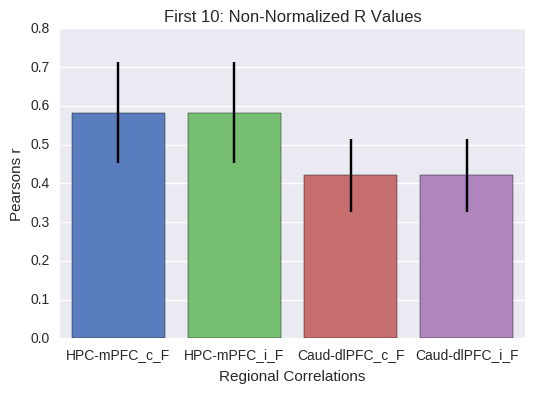

In [32]:
import seaborn as sns
#sns.set_style("ticks")
sns.set_palette('muted')
import matplotlib.pyplot as plt

N = 4
conditions = ['HPC-mPFC_c_F', 'HPC-mPFC_i_F', 'Caud-dlPFC_c_F', 'Caud-dlPFC_i_F']
means_allsubjs = [np.average(corr_chart['HPC-mPFC_c_F']), 
                  np.average(corr_chart['HPC-mPFC_i_F']),
                  np.average(corr_chart['Caud-dlPFC_c_F']), 
                  np.average(corr_chart['Caud-dlPFC_i_F'])]
sem_allsubjs = [np.average(corr_chart['HPC-mPFC_c_F']/(np.sqrt(len(sids)))), 
                np.average(corr_chart['HPC-mPFC_i_F']/(np.sqrt(len(sids)))),
                np.average(corr_chart['Caud-dlPFC_c_F']/(np.sqrt(len(sids)))), 
                np.average(corr_chart['Caud-dlPFC_i_F']/(np.sqrt(len(sids))))]
print np.average(corr_chart['HPC-mPFC_c_F'])
print np.average(corr_chart['HPC-mPFC_i_F'])
print np.average(corr_chart['Caud-dlPFC_c_F'])
print np.average(corr_chart['Caud-dlPFC_i_F'])


ind = np.arange(N)
width = 0.5

fig, ax = plt.subplots()

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax = sns.barplot(ind, means_allsubjs, yerr = sem_allsubjs, ecolor = 'black')

ax.set_xticks(ind)
ax.set_xticklabels(conditions)
#ax.set_ylim(0,1)
ax.set_ylabel("Pearsons r")
ax.set_xlabel("Regional Correlations")
ax.set_title("First 10: Non-Normalized R Values")
plt.show()

0.359589007642
0.359589007642
0.41435232847
0.41952239839


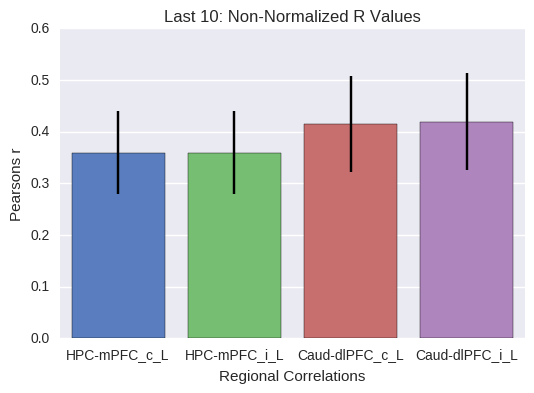

In [31]:
import seaborn as sns
#sns.set_style("ticks")
sns.set_palette('muted')
import matplotlib.pyplot as plt

N = 4
conditions = ['HPC-mPFC_c_L', 'HPC-mPFC_i_L', 'Caud-dlPFC_c_L', 'Caud-dlPFC_i_L']
means_allsubjs = [np.average(corr_chart['HPC-mPFC_c_L']), 
                  np.average(corr_chart['HPC-mPFC_i_L']),
                  np.average(corr_chart['Caud-dlPFC_c_L']), 
                  np.average(corr_chart['Caud-dlPFC_i_L'])]
sem_allsubjs = [np.average(corr_chart['HPC-mPFC_c_L']/(np.sqrt(len(sids)))), 
                np.average(corr_chart['HPC-mPFC_i_L']/(np.sqrt(len(sids)))),
                np.average(corr_chart['Caud-dlPFC_c_L']/(np.sqrt(len(sids)))), 
                np.average(corr_chart['Caud-dlPFC_i_L']/(np.sqrt(len(sids))))]
print np.average(corr_chart['HPC-mPFC_c_L'])
print np.average(corr_chart['HPC-mPFC_i_L'])
print np.average(corr_chart['Caud-dlPFC_c_L'])
print np.average(corr_chart['Caud-dlPFC_i_L'])


ind = np.arange(N)
width = 0.5

fig, ax = plt.subplots()

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax = sns.barplot(ind, means_allsubjs, yerr = sem_allsubjs, ecolor = 'black')

ax.set_xticks(ind)
ax.set_xticklabels(conditions)
#ax.set_ylim(0,1)
ax.set_ylabel("Pearsons r")
ax.set_xlabel("Regional Correlations")
ax.set_title("Last 10: Non-Normalized R Values")
plt.show()

## Normalized correlation matrix for beta series

In [33]:
# Use Numpy's arctangent function to normalize correlations
norm_corr = np.arctanh(corr_matrix[:, 1:])
#print(norm_corr)

In [36]:
import pandas as pd
norm_chart = {}
norm_chart['HPC-mPFC_c_F'] = norm_corr[:, 0] #F10_hpc-mpfc corr
norm_chart['HPC-mPFC_i_F'] = norm_corr[:, 1] #F10_hpc-mpfc incorr
norm_chart['HPC-mPFC_c_L'] = norm_corr[:, 2] #L10_hpc-mpfc corr
norm_chart['HPC-mPFC_i_L'] = norm_corr[:, 3] #L10_hpc-mpfc incorr
norm_chart['Caud-dlPFC_C_F'] = norm_corr[:, 4] #F10_caudate-dlpfc corr
norm_chart['Caud-dlPFC_i_F'] = norm_corr[:, 5] #F10_caudate-dlpfc incorr
norm_chart['Caud-dlPFC_C_L'] = norm_corr[:, 6] #L10_caudate-dlpfc corr
norm_chart['Caud-dlPFC_i_L'] = norm_corr[:, 7] #L10_caudate-dlpfc incorr
norm_chart_df = pd.DataFrame.from_dict(norm_chart)

In [37]:
norm_chart_df

,Caud-dlPFC_C_F,Caud-dlPFC_C_L,Caud-dlPFC_i_F,Caud-dlPFC_i_L,HPC-mPFC_c_F,HPC-mPFC_c_L,HPC-mPFC_i_F,HPC-mPFC_i_L
0,-0.193562,0.935007,-0.193562,0.935007,0.633545,0.612794,0.633545,0.612794
1,0.833343,-0.049195,0.833343,-0.049195,0.968485,0.730886,0.968485,0.730886
2,0.122173,-0.385716,0.122173,-0.385716,0.818856,1.262491,0.818856,1.262491
3,0.064604,1.033669,0.064604,1.033669,1.166421,1.186693,1.166421,1.186693
4,0.396959,1.031560,0.396959,1.031560,0.928894,0.996342,0.928894,0.996342
5,0.882847,1.035524,0.882847,1.035524,0.647717,0.891506,0.647717,0.891506
6,0.842421,-0.169364,0.842421,-0.042644,0.878534,0.910911,0.878534,0.910911
7,-0.411844,0.070253,-0.411844,0.070253,0.806042,0.253572,0.806042,0.253529
8,1.154758,0.022938,1.154758,0.001190,0.286300,-0.037545,0.286300,-0.037573
9,0.989106,1.077769,0.989106,1.077769,0.195850,-0.287874,0.195850,-0.287874


### Descriptive Statistics

In [38]:
# HPC & mPFC

print "Mean: F10_HPC-mPFC_corr"
print np.average(norm_corr[:, 0])
print "SD: F10_HPC-mPFC_corr"
print np.std(norm_corr[:, 0])
print ""
print "Mean: F10_HPC-mPFC_incorr"
print np.average(norm_corr[:, 1])
print "SD: F10_HPC-mPFC_incorr"
print np.std(norm_corr[:, 1])
print ""
print "Mean: L10_HPC-mPFC_corr"
print np.average(norm_corr[:, 2])
print "SD: L10_HPC-mPFC_corr"
print np.std(norm_corr[:, 2])
print ""
print "Mean: L10_HPC-mPFC_incorr"
print np.average(norm_corr[:, 3])
print "SD: L10_HPC-mPFC_incorr"
print np.std(norm_corr[:, 3])
print ""

#Caudate & dl PFC

print "Mean: F10_Caudate-dlPFC_corr"
print np.average(norm_corr[:, 4])
print "SD: F10_Caudate-dlPFC_corr"
print np.std(norm_corr[:, 4])
print ""
print "Mean: F10_Caudate-dlPFC_incorr"
print np.average(norm_corr[:, 5])
print "SD: F10_Caudate-dlPFC_incorr"
print np.std(norm_corr[:, 5])
print ""
print "Mean: L10_Caudate-dlPFC_corr"
print np.average(norm_corr[:, 6])
print "SD: L10_Caudate-dlPFC_corr"
print np.std(norm_corr[:, 6])
print ""
print "Mean: L10_Caudate-dlPFC_incorr"
print np.average(norm_corr[:, 7])
print "SD: L10_Caudate-dlPFC_incorr"
print np.std(norm_corr[:, 7])

Mean: F10_HPC-mPFC_corr
0.735807243604
SD: F10_HPC-mPFC_corr
0.36416953765

Mean: F10_HPC-mPFC_incorr
0.735807243604
SD: F10_HPC-mPFC_incorr
0.36416953765

Mean: L10_HPC-mPFC_corr
0.585985342705
SD: L10_HPC-mPFC_corr
0.59982850578

Mean: L10_HPC-mPFC_incorr
0.585981833856
SD: L10_HPC-mPFC_incorr
0.59983117467

Mean: F10_Caudate-dlPFC_corr
0.456039767946
SD: F10_Caudate-dlPFC_corr
0.479216734492

Mean: F10_Caudate-dlPFC_incorr
0.456039767946
SD: F10_Caudate-dlPFC_incorr
0.479216734492

Mean: L10_Caudate-dlPFC_corr
0.596831997436
SD: L10_Caudate-dlPFC_corr
0.636712472513

Mean: L10_Caudate-dlPFC_incorr
0.602080625474
SD: L10_Caudate-dlPFC_incorr
0.630666788575


### Inferential Statistics

In [23]:
print 'T-test: HPC-mPFC_corr_F10 vs. HPC-mPFC_incorr_F10'
print stats.ttest_rel(norm_corr[:, 0], norm_corr[:, 1])
print ""

print 'T-test: HPC-mPFC_corr_L10 vs. HPC-mPFC_incorr_L10'
print stats.ttest_rel(norm_corr[:, 2], norm_corr[:, 3])
print ""

print 'T-test: Caudate-dlPFC_corr_F10 vs. Caudate-dlPFC_incorr_F10'
print stats.ttest_rel(norm_corr[:, 4], norm_corr[:, 5])
print ""

print 'T-test: Caudate-dlPFC_corr_L10 vs. Caudate-dlPFC_incorr_L10'
print stats.ttest_rel(norm_corr[:, 6], norm_corr[:, 7])
print ""

print "Bonferroni correction"
print '0.05/4 = 0.0125'

T-test: HPC-mPFC_corr_F10 vs. HPC-mPFC_incorr_F10
Ttest_relResult(statistic=nan, pvalue=nan)

T-test: HPC-mPFC_corr_L10 vs. HPC-mPFC_incorr_L10
Ttest_relResult(statistic=1.4077284533505565, pvalue=0.1753624646942061)

T-test: Caudate-dlPFC_corr_F10 vs. Caudate-dlPFC_incorr_F10
Ttest_relResult(statistic=nan, pvalue=nan)

T-test: Caudate-dlPFC_corr_L10 vs. Caudate-dlPFC_incorr_L10
Ttest_relResult(statistic=-0.80937544709544973, pvalue=0.42831933957289636)

Bonferroni correction
0.05/4 = 0.0125


## Scatterplots illustrating regional activation across trials: Single subject

### Hippocampus vs. mPFC: Fixed before CORRECT

16


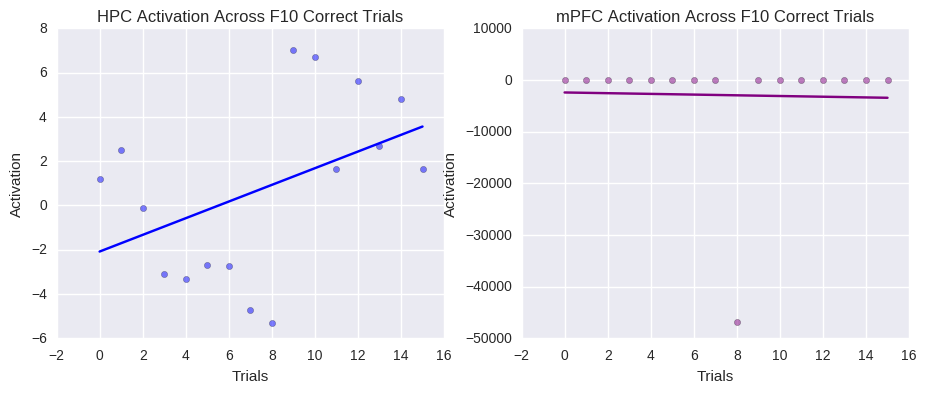

In [58]:
%matplotlib inline
# Scatterplot

ax = []
for a in range(0,16,1):
    ax.append(a)

x = ax

#print len(x)
y = all_data['hp_corr_F10']
z = all_data['mPFC_corr_F10']
print len(y)
#print len(z)


fig, (ax, ax2) = plt.subplots(ncols = 2, figsize=(11, 4), sharex = True, sharey = False)
fit = np.polyfit(x, y, deg = 1)
ax.plot(x, np.array(fit[0]) * np.array(x) + np.array(fit[1]), color = 'blue')
ax.scatter(x, y, c = 'blue', alpha = 0.5)
ax.set_ylabel('Activation')
ax.set_xlabel('Trials')
ax.set_title('HPC Activation Across F10 Correct Trials')


fit2 = np.polyfit(x, z, deg = 1)
ax2.plot(x, np.array(fit2[0]) * np.array(x) + np.array(fit2[1]), color = 'purple')
ax2.scatter(x, z, c = 'purple', alpha = 0.5)
ax2.set_ylabel('Activation')
ax2.set_xlabel('Trials')
ax2.set_title('mPFC Activation Across F10 Correct Trials')


16


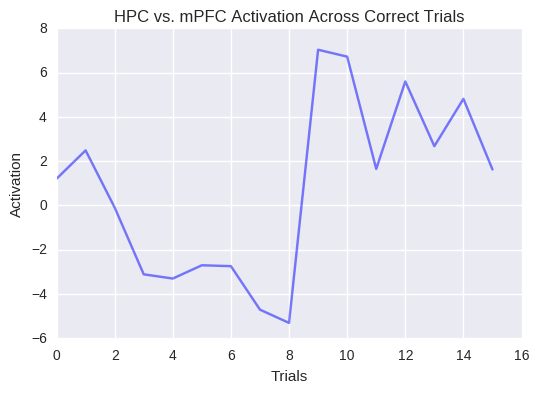

In [57]:
%matplotlib inline
# Scatterplot

ax = []
for a in range(0,16,1):
    ax.append(a)

x = ax

#print len(x)
y = all_data['hp_corr_F10']
z = all_data['hp_corr_L10']
print len(y)
#print len(z)

#fit = np.polyfit(x, y, deg = 1)
#plt.plot(x, np.array(fit[0]) * np.array(x) + np.array(fit[1]), color = 'blue')
plt.plot(x, y, c = 'blue', alpha = 0.5)

#fit2 = np.polyfit(x, z, deg = 1)
#plt.plot(x, np.array(fit2[0]) * np.array(x) + np.array(fit2[1]), color = 'purple')
#plt.plot(x, z, c = 'purple', alpha = 0.5)

plt.ylabel('Activation')
plt.xlabel('Trials')
plt.title('HPC vs. mPFC Activation Across Correct Trials')
plt.show()

### Hippocampus vs. mPFC: Fixed before INCORRECT

14


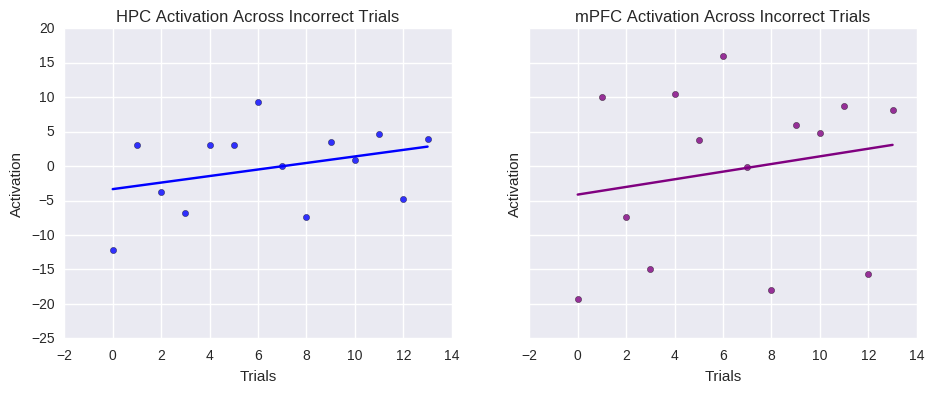

In [59]:
%matplotlib inline
# Scatterplot

ax = []
for a in range(0,14,1):
    ax.append(a)

x = ax

#print len(x)
y = all_data['hp_incorr_F10']
z = all_data['mPFC_incorr_F10']
print len(y)
#print len(z)

fig, (ax, ax2) = plt.subplots(ncols = 2, figsize=(11, 4), sharex = True, sharey = True)
fit = np.polyfit(x, y, deg = 1)
ax.plot(x, np.array(fit[0]) * np.array(x) + np.array(fit[1]), color = 'blue')
ax.scatter(x, y, c = 'blue', alpha = 0.8)
ax.set_ylabel('Activation')
ax.set_xlabel('Trials')
ax.set_title('HPC Activation Across Incorrect Trials')


fit2 = np.polyfit(x, z, deg = 1)
ax2.plot(x, np.array(fit2[0]) * np.array(x) + np.array(fit2[1]), color = 'purple')
ax2.scatter(x, z, c = 'purple', alpha = 0.8)
ax2.set_ylabel('Activation')
ax2.set_xlabel('Trials')
ax2.set_title('mPFC Activation Across Incorrect Trials')

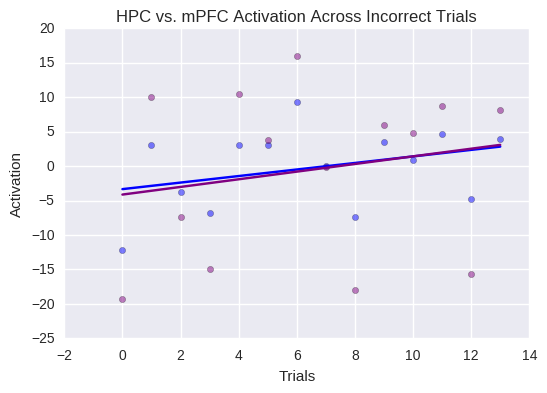

In [60]:
%matplotlib inline
# Scatterplot

ax = []
for a in range(0,14,1):
    ax.append(a)

x = ax

#print len(x)
y = all_data['hp_incorr_F10']
z = all_data['mPFC_incorr_F10']
#print len(y)
#print len(z)

fit = np.polyfit(x, y, deg = 1)
plt.plot(x, np.array(fit[0]) * np.array(x) + np.array(fit[1]), color = 'blue')
plt.scatter(x, y, c = 'blue', alpha = 0.5)

fit2 = np.polyfit(x, z, deg = 1)
plt.plot(x, np.array(fit2[0]) * np.array(x) + np.array(fit2[1]), color = 'purple')
plt.scatter(x, z, c = 'purple', alpha = 0.5)

plt.ylabel('Activation')
plt.xlabel('Trials')
plt.title('HPC vs. mPFC Activation Across Incorrect Trials')
plt.show()

### Caudate vs. dlPFC: Fixed before CORRECT

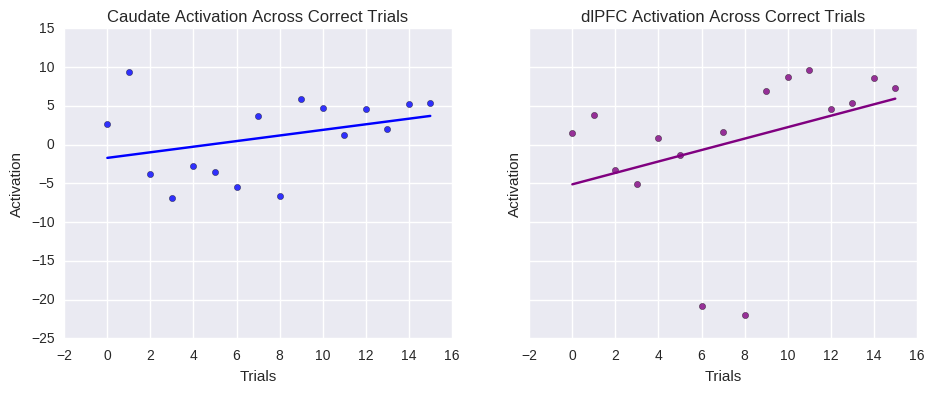

In [61]:
%matplotlib inline
# Scatterplot

ax = []
for a in range(0,16,1):
    ax.append(a)

x = ax

#print len(x)
y = all_data['caudate_corr_F10']
z = all_data['dlPFC_corr_F10']
#print len(y)
#print len(z)

fig, (ax, ax2) = plt.subplots(ncols = 2, figsize=(11, 4), sharex = True, sharey = True)
fit = np.polyfit(x, y, deg = 1)
ax.plot(x, np.array(fit[0]) * np.array(x) + np.array(fit[1]), color = 'blue')
ax.scatter(x, y, c = 'blue', alpha = 0.8)
ax.set_ylabel('Activation')
ax.set_xlabel('Trials')
ax.set_title('Caudate Activation Across Correct Trials')


fit2 = np.polyfit(x, z, deg = 1)
ax2.plot(x, np.array(fit2[0]) * np.array(x) + np.array(fit2[1]), color = 'purple')
ax2.scatter(x, z, c = 'purple', alpha = 0.8)
ax2.set_ylabel('Activation')
ax2.set_xlabel('Trials')
ax2.set_title('dlPFC Activation Across Correct Trials')

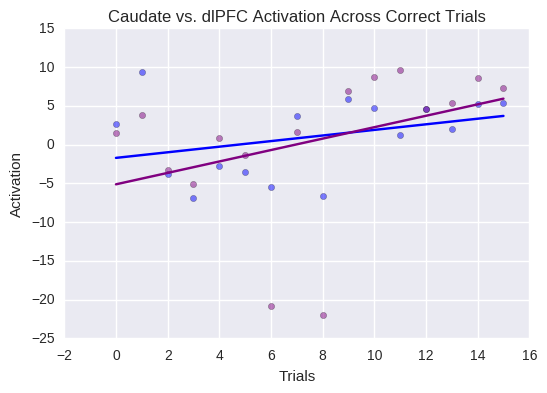

In [62]:
%matplotlib inline
# Scatterplot

ax = []
for a in range(0,16,1):
    ax.append(a)

x = ax

#print len(x)
y = all_data['caudate_corr_F10']
z = all_data['dlPFC_corr_F10']
#print len(y)
#print len(z)

fit = np.polyfit(x, y, deg = 1)
plt.plot(x, np.array(fit[0]) * np.array(x) + np.array(fit[1]), color = 'blue')
plt.scatter(x, y, c = 'blue', alpha = 0.5)

fit2 = np.polyfit(x, z, deg = 1)
plt.plot(x, np.array(fit2[0]) * np.array(x) + np.array(fit2[1]), color = 'purple')
plt.scatter(x, z, c = 'purple', alpha = 0.5)

plt.ylabel('Activation')
plt.xlabel('Trials')
plt.title('Caudate vs. dlPFC Activation Across Correct Trials')
plt.show()

### Caudate vs. dlPFC: Fixed before INCORRECT

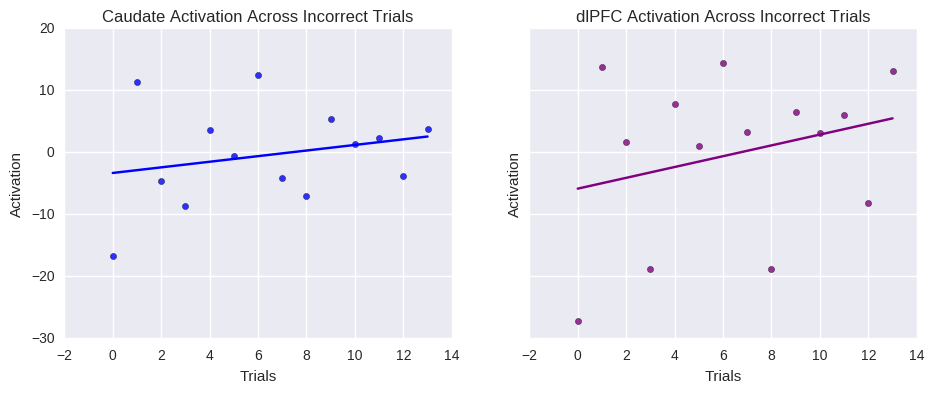

In [63]:
%matplotlib inline
# Scatterplot

ax = []
for a in range(0,14,1):
    ax.append(a)

x = ax

#print len(x)
y = all_data['caudate_incorr_F10']
z = all_data['dlPFC_incorr_F10']
#print len(y)
#print len(z)

fig, (ax, ax2) = plt.subplots(ncols = 2, figsize=(11, 4), sharex = True, sharey = True)
fit = np.polyfit(x, y, deg = 1)
ax.plot(x, np.array(fit[0]) * np.array(x) + np.array(fit[1]), color = 'blue')
ax.scatter(x, y, c = 'blue', alpha = 0.8)
ax.set_ylabel('Activation')
ax.set_xlabel('Trials')
ax.set_title('Caudate Activation Across Incorrect Trials')

fit2 = np.polyfit(x, z, deg = 1)
ax2.plot(x, np.array(fit2[0]) * np.array(x) + np.array(fit2[1]), color = 'purple')
ax2.scatter(x, z, c = 'purple', alpha = 0.8)
ax2.set_ylabel('Activation')
ax2.set_xlabel('Trials')
ax2.set_title('dlPFC Activation Across Incorrect Trials')

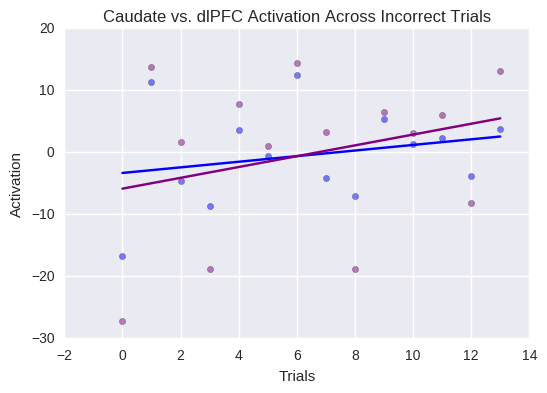

In [64]:
%matplotlib inline
# Scatterplot

ax = []
for a in range(0,14,1):
    ax.append(a)

x = ax

#print len(x)
y = all_data['caudate_incorr_F10']
z = all_data['dlPFC_incorr_F10']
#print len(y)
#print len(z)

fit = np.polyfit(x, y, deg = 1)
plt.plot(x, np.array(fit[0]) * np.array(x) + np.array(fit[1]), color = 'blue')
plt.scatter(x, y, c = 'blue', alpha = 0.5)

fit2 = np.polyfit(x, z, deg = 1)
plt.plot(x, np.array(fit2[0]) * np.array(x) + np.array(fit2[1]), color = 'purple')
plt.scatter(x, z, c = 'purple', alpha = 0.5)

plt.ylabel('Activation')
plt.xlabel('Trials')
plt.title('Caudate vs. dlPFC Activation Across Incorrect Trials')
plt.show()